## Inference One Video and Visualize the Knowledge Graph.
Fast Demo: Load processed clips and do not host CNN.

In [1]:
import base64
import os
import sys
import pickle

import cv2
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

from IPython.display import display
from IPython.display import HTML
from IPython.display import Javascript

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import rs utils
sys.path.append(ROOT_DIR)  # To find local version of the library
from rs.config import Config
from rs.models import *
from rs import utils
from rs import visualize
from rs.datasets import loader
from token2tag import *

In [2]:
# Configuration for hperparameters
class InferenceConfig(Config):
    """Configuration for training with RS-RGBD.
    """
    NAME = 'v2l_RS-RGBD'
    MODE = 'eval'
    ROOT_DIR = ROOT_DIR
    CHECKPOINT_PATH = os.path.join(ROOT_DIR, 'checkpoints')
    DATASET_PATH = os.path.join(ROOT_DIR, 'data', 'RS-RGBD')
    ONTO_FILE = os.path.join(DATASET_PATH, 'object_onto.owl')
    
    ### ------------ Modify params here ------------ ###
    BACKBONE = 'resnet50'
    LOAD_CNN = True
    WEIGHTS_PATH = os.path.join(ROOT_DIR, 'checkpoints', 'weights', '{}.pth'.format(BACKBONE))
    CHECKPOINT_FILE = os.path.join(CHECKPOINT_PATH, 'saved', 'v2l_trained.pth')
    TASK = 'eval_wam_grasp_pour'
    VIDEO_NAME = 'wam_unknown_water_plasticbottle1_glasscup3'
    VIDEO_PATH = os.path.join(DATASET_PATH,
                              TASK,
                              VIDEO_NAME, VIDEO_NAME)
    UPSAMPLE_METHOD = 'pyramid'
    ### ------------ End of Modification ----------- ###

## Some Helper Functions
Helpers to generate clip, visualize attention, etc.

In [3]:
def init_model(config, 
               vocab,
               CHECKPOINT_FILE):
    # --------------------
    # Setup and build video2lang training inference
    v2l_model = Video2Lang(config, vocab)
    v2l_model.build(None)

    # Load back weights
    v2l_model.load_weights(CHECKPOINT_FILE)
    return v2l_model

def load_video(video_path, 
               f_format='%d_rgb.png'):
    """OpenCV video stream wrapper to collect all frames.
    """
    src = os.path.join(video_path, f_format)
    cap = cv2.VideoCapture(src)
    frames = []
    while True:
        ret, frame = cap.read()
        if frame is not None:
            frames.append(frame)
        else:
            break
    cap.release()
    return frames

def preprocess_clip(clip):
    """Wrapper func to preprocess a clip.
    """
    clip = [loader.transforms_data(Image.fromarray(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))) for x in clip]
    return torch.stack(clip)

def generate_clips(frames, 
                   config):
    """Generate clips using video stream object.
    """
    stream = utils.StreamSimple(window_size=config.WINDOW_SIZE)
    clips = []
    indices = []
    for i, frame in enumerate(frames):
        stream.add_frame(frame)
        clip = stream.get_clip()
        if clip is not None:
            clip = preprocess_clip(clip)
            clips.append(clip)
            start_index = i - config.WINDOW_SIZE + 1
            indices.append((start_index, i))

    # Force retrieve the last clip
    clip = stream.get_clip(forced_retrieve=True)
    clip = preprocess_clip(clip)
    clips.append(clip)
    start_index = i - config.WINDOW_SIZE + 1
    indices.append((start_index, i))
    return clips, indices

def show_video(video_path):
    """Display an mp4 video in jupyter.
    """
    mp4 = open(video_path, 'rb').read()
    data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML("""<video width=600 controls>
                <source src="%s" type="video/mp4"></video>
                """ % data_url)

def show_clip(frames,
              interval=30,
              plot_score=True,
              fps=10):
    tmp_path = 'output.mp4'
    
    num_frames = len(frames)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    im0 = ax.imshow(frames[0])
    
    def update(i):
        im0.set_data(frames[i])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()

    anim = FuncAnimation(fig,
                         update,
                         frames=num_frames,
                         interval=interval,
                         blit=False)
    anim.save(tmp_path, fps=fps)
    plt.close()
    return show_video(tmp_path)

## Inference
Test the inference of video2command model.

In [4]:
# Setup configuration class
config = InferenceConfig()

# Load v2l model
vocab = pickle.load(open(os.path.join(config.CHECKPOINT_PATH, 'vocab.pkl'), 'rb'))
config.VOCAB_SIZE = len(vocab)
v2l_model = init_model(config, vocab, config.CHECKPOINT_FILE)
config.display()

Loading...
Model loaded.

Configurations:
------------------------------
ANNOT_TO_USE                   command
BACKBONE                       resnet50
BATCH_SIZE                     16
CHECKPOINT_FILE                /home/ubuntu/Desktop/workspace/robot_semantics/checkpoints/saved/v2l_trained.pth
CHECKPOINT_PATH                /home/ubuntu/Desktop/workspace/robot_semantics/checkpoints
CLIP_NORM                      5.0
DATASET_PATH                   /home/ubuntu/Desktop/workspace/robot_semantics/data/RS-RGBD
DISPLAY_EVERY                  20
EMBED_DIM                      256
END_WORD                       <eos>
FREQUENCY                      None
LEARNING_RATE                  0.0001
LOAD_CNN                       True
LR_DECAY_EVERY                 [5, 40]
MAXLEN                         10
MODE                           eval
NAME                           v2l_RS-RGBD
NUM_EPOCHS                     50
ONTO_FILE                      /home/ubuntu/Desktop/workspace/robot_semantics/data/R

In [5]:
# Collect video and generate clips
print('Loading video...')
frames = load_video(config.VIDEO_PATH)
print('No. frames:', len(frames), frames[0].shape)

print('Generating clips...')
clips, indices = generate_clips(frames, config)
print("No. clips:", len(clips))

Loading video...
No. frames: 1569 (720, 1280, 3)
Generating clips...
No. clips: 104


In [6]:
# State the clip index to be used
### ------------ Modify params here ------------ ###
idx = 54
### ------------ End of Modification ----------- ###

clip, indices_clip = clips[idx], indices[idx]
frames_clip = frames[indices_clip[0]:indices_clip[1]]
print('Clip Indices:', indices_clip)

# Inference START HERE
clip = clip.to(v2l_model.device)
S = v2l_model.predict(clip)

# Collect result to CPU
S = S.cpu().numpy()[0]
img_shape = frames_clip[0].shape[:2]
text = utils.sequence_to_text(S, vocab)

Clip Indices: (810, 839)


In [7]:
# Only visualize DKG against one prediction
texts = [text]

## Ontology & DKG Visualization
Here, we use the dynamic command sentence as the base knowledge graph. We loop through each word tokens(entities), retrieving known external knowledge stored inside a static ontology.

In [8]:
# --------------------
# Init ontology model
onto = utils.init_onto(config.ONTO_FILE)

Loaded owl file at: file:///home/ubuntu/Desktop/workspace/robot_semantics/data/RS-RGBD/object_onto.owl


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /usr/local/lib/python3.6/dist-packages/owlready2/hermit:/usr/local/lib/python3.6/dist-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmp_an38gr5
* Owlready2 * HermiT took 0.7003896236419678 seconds
* Owlready * Reparenting object_onto.hasEntityPresented: {owl.ObjectProperty, object_onto.topContextClassProperty} => {object_onto.topContextClassProperty}
* Owlready * Reparenting object_onto.hasGenericTemperature: {owl.ObjectProperty, object_onto.topClassProperty} => {object_onto.topClassProperty}
* Owlready * Reparenting object_onto.hasFoodInsideGeneric: {owl.ObjectProperty, object_onto.topClassProperty} => {object_onto.topClassProperty}
* Owlready * Reparenting object_onto.hasMaterial: {owl.ObjectProperty, object_onto.topClassProperty, owl.FunctionalProperty} => {object_onto.topClassProperty, owl.FunctionalProperty}
* Owlready * Reparenting object_onto.canWithstandTemperature: {ow

## Base Knowledge Graph
Now let's see what the base skeleton knowledge graph looks like for a single video. A simple concatenation to grab all edges.

1
Base Knowledge Graph: [('Wam', 'V2C_HOLD', 'PlasticBottle')]


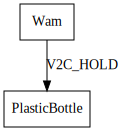

In [9]:
graph = utils.sentence_to_graph(texts[0], token2tag)
print(len(texts))
for i in range(len(texts)):
    graph_curr = utils.sentence_to_graph(texts[i], token2tag)
    for edge in graph_curr:
        if edge not in graph:
            graph.append(edge)
            
print('Base Knowledge Graph:', graph)
e = visualize.convert_to_graphviz(graph, engine='dot')
e

## External Knowledge
Search for external knowledge from ontology itself.

In [10]:
# Search ontology, grab external knowledge
graph_from_onto = []
for text in texts:
    graph_from_onto_curr = utils.retrieve_knowledge_graph(text, token2tag, onto)
    for edge in graph_from_onto_curr:
        if edge not in graph_from_onto:
            graph_from_onto.append(edge)
print()
print('External Knowledge Graph:')
print('-'*20)
print(graph_from_onto)


External Knowledge Graph:
--------------------
[('PlasticBottle', 'hasMaterial, some', 'Plastic'), ('PlasticBottle', 'subclass_of', 'Bottle'), ('PlasticBottle', 'isGraspableBy, some', 'HumanHand'), ('PlasticBottle', 'isGraspableBy, some', 'KinovaArm'), ('PlasticBottle', 'isGraspableBy, some', 'WAMArm'), ('Bottle', 'has_subclass', 'PlasticBottle'), ('HumanHand', 'canGrasp, some', 'PlasticBottle'), ('KinovaArm', 'canGrasp, some', 'PlasticBottle'), ('WAMArm', 'canGrasp, some', 'PlasticBottle')]


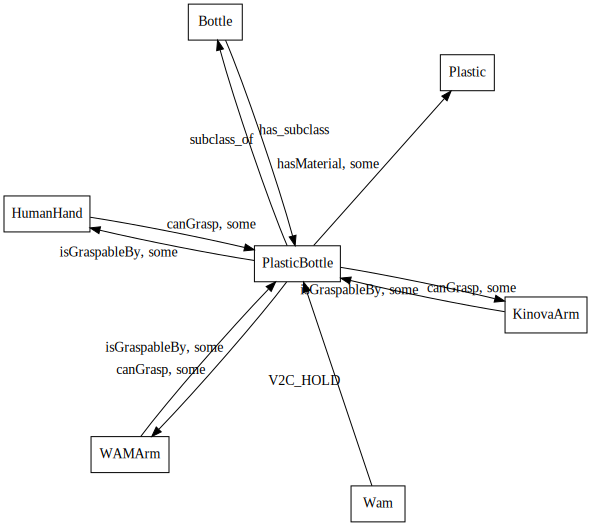

In [11]:
e = visualize.convert_to_graphviz(graph_from_onto + graph, engine='sfdp')
e.view()    # Save knowledge graph as a pdf
e